In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import open3d as o3d
image_filenames = sorted(glob.glob('C:/Users/DHRUV/Downloads/Sensing and perception/img??.jpeg')) 



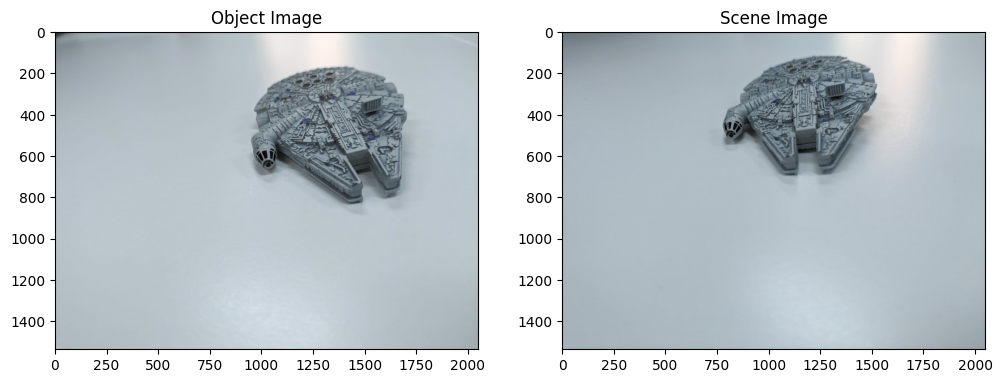

Object Image Shape: (1537, 2048)
Scene Image Shape: (1537, 2048)


In [59]:
img1 = cv2.imread('img02.jpeg')  # The object to detect
img2 = cv2.imread('img03.jpeg')  # The scene in which to find the object



plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Object Image')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Scene Image')
plt.show()


# Convert to grayscale
object_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Print the shape of the images
print(f'Object Image Shape: {object_gray.shape}')
print(f'Scene Image Shape: {scene_gray.shape}')


In [60]:
K = np.array([[1.66006937e+03, 0.00000000e+00, 1.02769927e+03],
 [0.00000000e+00, 1.65302995e+03, 8.28393603e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]
)
obj_func_val = 0.9239946188226292    #retval
distortion_coeff = [[4.52323122e-02, -2.70377423e-01, -2.79272176e-03,  2.04700952e-04,
   3.35548850e-01]]

In [61]:
bf = cv2.BFMatcher()
LOWE = 0.7
sift = cv2.SIFT_create(nfeatures=10000)

def get_matches(kp1, d1, kp2, d2):
  matches = bf.knnMatch(d1, d2, k=2)

  good_matches = [m for m,n in matches if m.distance < LOWE*n.distance] # Lowe's ratio test
  print('GOOD MATCHES: ', len(good_matches), ' out of total: ', len(matches))

  #Determine 2D coords of the same feature in each of the two images
  #(One pair of coords for each match)
  pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
  pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

  #Estimate the relative pose of the cameras
  E, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 500)
  _, R, t, _ = cv2.recoverPose(E, pts1, pts2, cameraMatrix=K, mask=mask)
  return pts1, pts2, mask, R, t, good_matches


#Display matches in two images
def display_matches(mask, img1, kp1, img2, kp2, good_matches):
  matchesMask = mask.ravel().tolist()
  draw_params = dict(matchColor = (0,255,0),
                    singlePointColor = None,
                    matchesMask = matchesMask,  # Draw only inliers
                    flags = 2)
  matched_img = cv2.drawMatches(img1,kp1,img2,kp2,good_matches,None,**draw_params)
  plt.imshow(matched_img, cmap='gray')
  plt.show()
  return matched_img


def feature_extract_sift(img1, img2, displaying_matches=False):
  kp1,d1 = sift.detectAndCompute(img1, None)
  kp2,d2 = sift.detectAndCompute(img2, None)
  pts1, pts2, mask, R, t, good_matches = get_matches(kp1, d1, kp2, d2)
  if displaying_matches:
    display_matches(mask, img1, kp1, img2, kp2, good_matches)
  return pts1, pts2, mask, R, t, good_matches


In [62]:
#Triangulate the features from a pair of images and generate a point cloud,
#Using the Camera's parameters and relative pose

def to_pointcloud(points_3D):
  #Convert numpy array to a open3d point cloud format
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(points_3D)
  return pcd

def triangulate(K, R, t, pts1, pts2):
  #Using Camera #1 as the origin and an empty projection matrix
  P1 = np.dot(K, np.hstack((np.identity(3), np.zeros((3, 1)))))
  #Camera #2 uses the relative rotation & translation as a projection matrix
  P2 = np.dot(K, np.hstack((R, t)))

  #Construct 3D point cloud and convert homogenous coordinates to cartesian
  points_3D = cv2.triangulatePoints(P1, P2, np.transpose(pts1), np.transpose(pts2))
  points_3D /= points_3D[3]
  points_3D = np.transpose(points_3D[:3,:])

  return to_pointcloud(points_3D)

#Remove outliers from the point cloud based on distance from nearest neighbours (measured in standard deviations of the distribution)
def filter_outliers(pcd):
  _, indices_of_inliers = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=1)
  inlier_cloud = pcd.select_by_index(indices_of_inliers)
  return inlier_cloud

GOOD MATCHES:  276  out of total:  3907


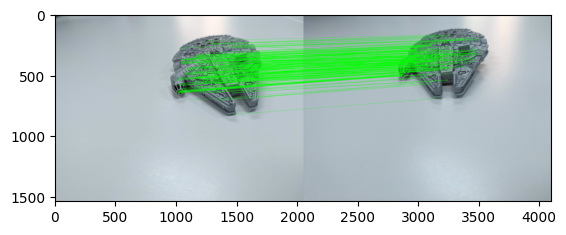

GOOD MATCHES:  13  out of total:  3247


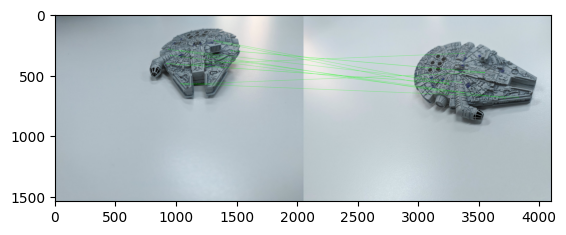

GOOD MATCHES:  1522  out of total:  4800


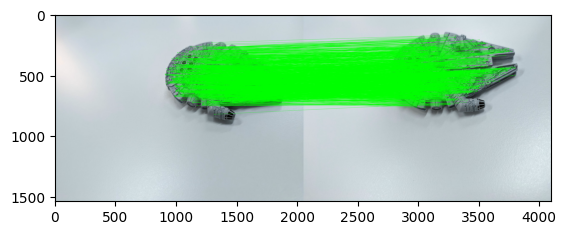

GOOD MATCHES:  25  out of total:  5676


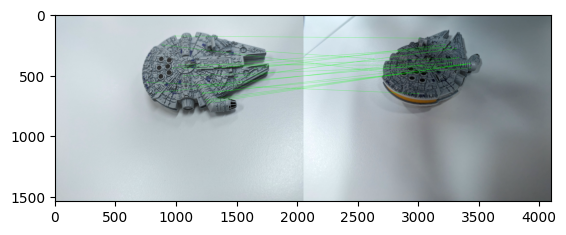

GOOD MATCHES:  10  out of total:  2339


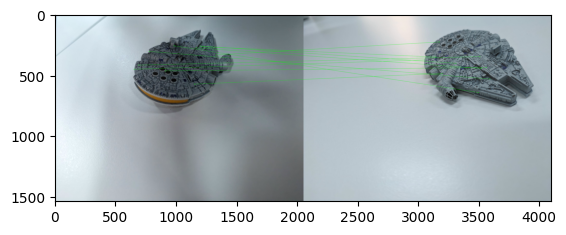

GOOD MATCHES:  15  out of total:  3026


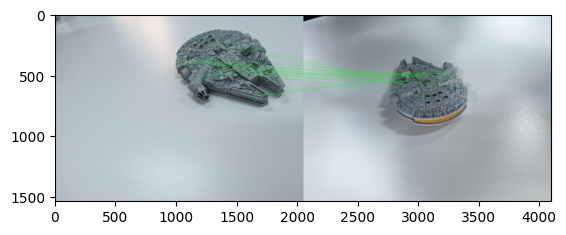

GOOD MATCHES:  218  out of total:  3281


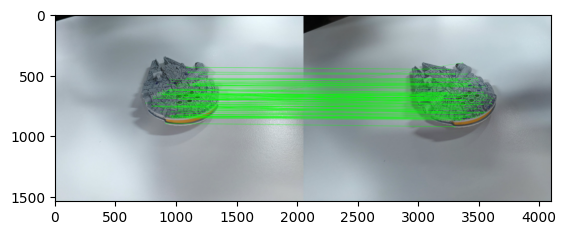

GOOD MATCHES:  8  out of total:  2748


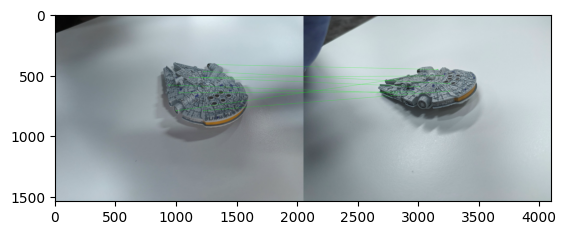

GOOD MATCHES:  304  out of total:  3265


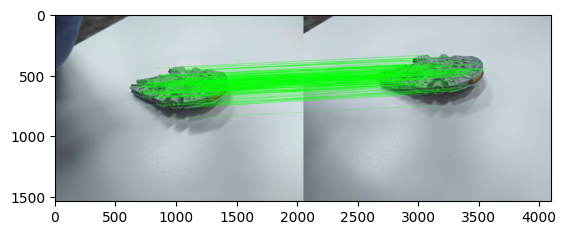

GOOD MATCHES:  208  out of total:  3086


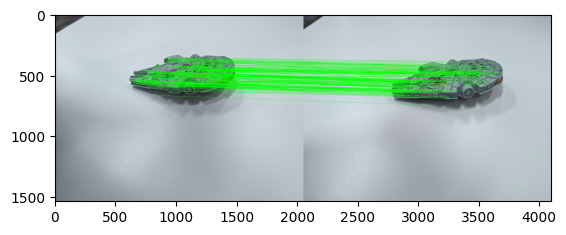

GOOD MATCHES:  5  out of total:  3048


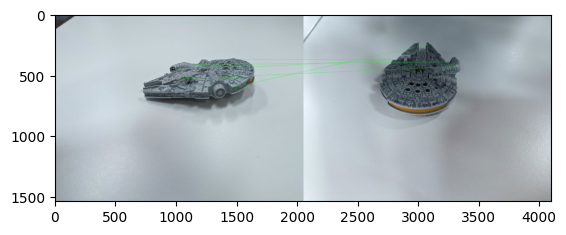

GOOD MATCHES:  9  out of total:  2107


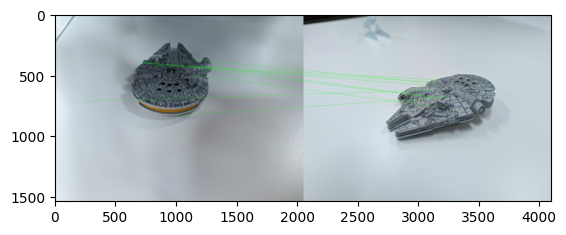

GOOD MATCHES:  876  out of total:  4591


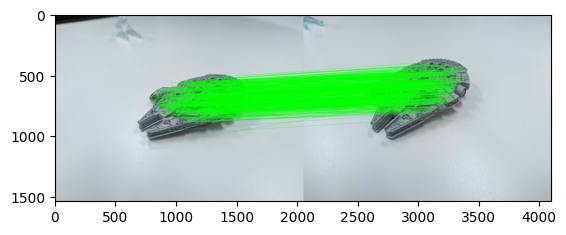

GOOD MATCHES:  234  out of total:  4974


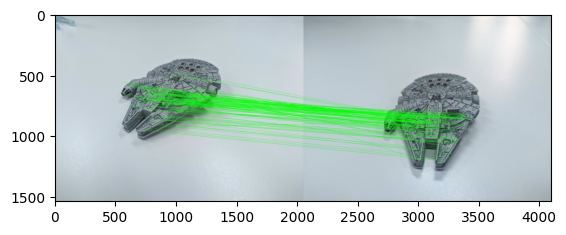

GOOD MATCHES:  16  out of total:  4269


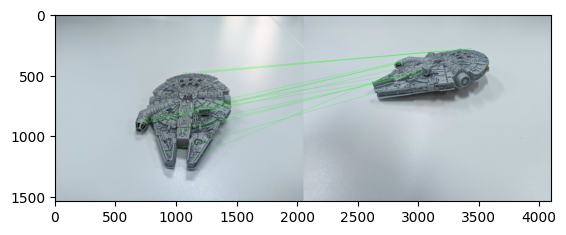

In [66]:
points_3D = np.empty((0, 3))


for current, next in zip(image_filenames,image_filenames[1:]):
  img1 = cv2.imread(current)
  img2 = cv2.imread(next)
  pts1, pts2, mask, R, t, good_matches = feature_extract_sift(img1, img2, displaying_matches=True)
  pcd = triangulate(K, R, t, pts1, pts2)
  inlier_cloud = filter_outliers(pcd)
  points_3D = np.concatenate((points_3D, inlier_cloud.points), axis=0)
  o3d.visualization.draw_plotly([inlier_cloud])

#Sparse Reconstruction
pcd = to_pointcloud(points_3D)
o3d.visualization.draw_plotly([pcd])

In [67]:
mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(pcd)
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, 1, mesh, pt_map)
mesh.compute_vertex_normals()
o3d.visualization.draw_plotly([mesh])

In [65]:
o3d.io.write_triangle_mesh("output_mesh.stl", mesh)

True